In [ ]:
"""
input:
    - date_topic_count_8_200_0.2.parquet
    - topics_8_200_0.2.parquet
    - main_configs.json

    - topic1.parquet
    - topic2.parquet
    - topic3.parquet
    - topic4.parquet
    - topic5.parquet
    - topic6.parquet
    - topic7.parquet
    - topic8.parquet

    - cleaned_probs_8_200_0.2.parquet
    - cleaned_world_anti_tweets_and_ids.parquet
    - date_and_bigram_collocations_df.parquet
    - 
output:
    - top_5_keywords_for_topic1.pdf
    - top_5_keywords_for_topic2.pdf
    - top_5_keywords_for_topic3.pdf
    - top_5_keywords_for_topic4.pdf
    - top_5_keywords_for_topic5.pdf
    - top_5_keywords_for_topic6.pdf
    - top_5_keywords_for_topic7.pdf
    - top_5_keywords_for_topic8.pdf
"""

In [2]:
import os
import nltk
import json
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt
from nltk.collocations import *
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.collocations import BigramCollocationFinder

In [4]:
combined_us_tweets_path = "data/raw/US_data_with_locations"

probs_path = "/data/processed/CTM/probs"
topics_path = "/data/processed/CTM/topics"
day_keyword_count_path = f"{topics_path}/day_keyword_count_for_topics_8_200_0.2"

supp_figures_path = "/figures/experimental/supp_figures"
main_figures_path = "/figures/experimental/main_figures"
dataframes_path = "/data/processed/dataframes"

In [5]:
date_topic_count = pd.read_parquet(f"{dataframes_path}/date_topic_count_8_200_0.2.parquet")
top_50_keywords = pd.read_parquet(f"{topics_path}/topics_8_200_0.2.parquet")

with open("/src/main_configs.json", 'r') as f:
    main_configs = json.load(f)

In [9]:
date_topic_count['date'] = pd.to_datetime(date_topic_count['date'])

os.makedirs(f"{supp_figures_path}/topic_keyword_counts", exist_ok=True)

In [10]:
def gaussian_smooth(x, y, grid, sd):
    weights = np.transpose([stats.norm.pdf(grid, m, sd) for m in x])
    weights = weights / weights.sum(0)
    return (weights * y).sum(1)

def smooth_value(df, column_name, range=(2020, 2022), smoothing_ratio = 0.008):
    grid = np.linspace(range[0], range[1], num=df.shape[0])
    smoothed_value = gaussian_smooth(grid, df[column_name].values, grid, smoothing_ratio)

    return smoothed_value

def add_text(df, palette_dict):
    ratio = df['perc'].max() - df['perc'].min()
    margin = (ratio * 0.05)
    added_values = []
    for kw in df['keyword'].unique():
        x = pd.to_datetime('11-01-2021')
        y = df[(df['keyword'] == kw) & (df['date'] == x)]['perc'].values[0] + margin
        for i in added_values:
            if abs(i - y) < margin:
                if i - y < 0:
                    y -= margin
                else:
                    y += margin
        plt.text(x, y, kw, fontsize=15, color=palette_dict[kw])
        added_values.append(y)

In [ ]:
smoothing_steps = 2
top_10_keywords_for_each_topic = {}
for topic in tqdm(range(1, 9)):
    topic_keywords = pd.read_parquet(f"{day_keyword_count_path}/topic{topic}.parquet")
    topic_keywords['date'] = pd.to_datetime(topic_keywords['date'])

    total_topic_count = date_topic_count[date_topic_count['topic'] == topic]
    topic_keywords = topic_keywords.join(total_topic_count.set_index('date'), on='date')
    topic_keywords['perc'] = topic_keywords['count'].values / topic_keywords['counts'].values

    margins = []
    for kw in topic_keywords['keyword'].unique():
        kw_df = topic_keywords[topic_keywords['keyword'] == kw]
        for _ in range(smoothing_steps):
            kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)
        
        margin = kw_df.sort_values('perc').iloc[[0, -1], -1].values
        margin = np.abs(margin[0] - margin[1])
        margins.append([kw, margin])

    kw_df = pd.DataFrame(margins, columns=['keyword', 'perc'])
    sorted_kw_df = kw_df.sort_values('perc', ascending=False)
    top_10_keywords_for_each_topic[topic] = sorted_kw_df.iloc[:10, 0].values.tolist()

### PMI

In [ ]:
nltk.download('all')
TOKENIZER = RegexpTokenizer(r"[\w']+")

In [13]:
topics_predictions_df = pd.read_parquet(f"{probs_path}/cleaned_probs_8_200_0.2.parquet")

world_anti_tweets_path = '/data/raw/cleaned_world_anti_tweets_and_ids.parquet'
world_anti_tweets = pd.read_parquet(world_anti_tweets_path)

In [14]:
world_anti_tweets.shape, topics_predictions_df.shape

((6462944, 3), (6462944, 8))

In [15]:
world_anti_tweets['topic'] = np.argmax(topics_predictions_df.values, axis=1).ravel() + 1
world_anti_tweets = world_anti_tweets.drop(columns=['cleaned_indices'])

### Text cleaning

In [20]:
stop_words = set(stopwords.words('english'))

def word_filter(text):
    filtered_text = []
    for word in TOKENIZER.tokenize(text):
        if len(word) > 1 and word not in stop_words:
            filtered_text.append(word)
    
    return ' '.join(filtered_text)

def does_include_top_keywords(row_serie):
    topic = row_serie['topic']
    text = row_serie['text']

    text = text.split()
    for w in text:
        if w in top_10_keywords_for_each_topic[topic]:
            return True
    return False

In [21]:
filtered_world_anti_tweets = world_anti_tweets.copy(deep=True)

filtered_text = []
for text in tqdm(filtered_world_anti_tweets['text'].values):
    filtered_text.append(word_filter(text))

100%|██████████| 6462944/6462944 [01:48<00:00, 59677.31it/s]


In [22]:
filtered_world_anti_tweets = filtered_world_anti_tweets.drop(columns=['text'])
filtered_world_anti_tweets = pd.concat([filtered_world_anti_tweets, pd.DataFrame({'text': filtered_text})], axis=1)
del filtered_text

In [23]:
row_include_top_keywords = []
for idx, row_serie in tqdm(filtered_world_anti_tweets.iterrows()):
    row_include_top_keywords.append(does_include_top_keywords(row_serie))

filtered_world_anti_tweets = filtered_world_anti_tweets.loc[row_include_top_keywords, :].reset_index(drop=True)

6462944it [05:46, 18650.04it/s]


In [24]:
pos_encoding = {'NN':'n', 'NNS':'n', 'NNP':'n', 'NNPS':'n', 'PRP':'n',
                'PRP$':'n', 'VB':'v', 'VBD':'v', 'VBG':'v', 'VBN':'v',
                'VBP':'v', 'VBZ':'v', 'JJ':'a', 'JJR':'a', 'JJS':'a', 'RB':'r',
                'RBR':'r', 'RBS':'r'}

lemmatizer = WordNetLemmatizer()

In [ ]:
cleaned_texts = {}

for topic in tqdm(range(1, 9)):
    cleaned_texts[topic] = []
    for text in filtered_world_anti_tweets[filtered_world_anti_tweets['topic'] == topic]['text'].values:
        tagged_text = nltk.pos_tag(text.split())

        sub_cleaned_text = []
        for word in tagged_text:
            if pos_encoding.get(word[1], False):
                lemmatized_word = lemmatizer.lemmatize(word[0], pos=pos_encoding[word[1]])
            else:
                lemmatized_word = lemmatizer.lemmatize(word[0])

            sub_cleaned_text.append(lemmatized_word)
        cleaned_texts[topic].append(' '.join(sub_cleaned_text))

In [ ]:
pmis = {}

bigram_measures = nltk.collocations.BigramAssocMeasures()
words = []

for topic in range(1, 9):
    for texts in cleaned_texts[topic]:
        words.extend(texts.split())
        words.append('-')

finder = BigramCollocationFinder.from_words(words)
pmi_scores = finder.score_ngrams(bigram_measures.pmi)

In [ ]:
pmi_scores_df = [[i[0][0], i[0][1], i[1]] for i in pmi_scores]
pmi_scores_df = pd.DataFrame(pmi_scores_df, columns=['w1', 'w2', 'score'])

In [27]:
pmi_scores_df

,w1,w2,score
0,''Delta,Variant'',26.027530
1,''Freedom,Day'',26.027530
2,''Intentionally,Blank'',26.027530
3,''Made,China'',26.027530
4,''Mur,der'',26.027530
...,...,...,...
10026480,You,term,-9.596340
10026481,The,What,-9.858321
10026482,adverse,people,-10.266552
10026483,adverse,get,-10.361705


### Combining keywords based on pmi's

In [28]:
top_10_keywords_for_each_topic_stemmed = {}

for topic in range(1, 9):
    top_10_keywords_for_each_topic_stemmed[topic] = {}
    for word in top_10_keywords_for_each_topic[topic]:
        stemmed_word = lemmatizer.lemmatize(word)

        top_10_keywords_for_each_topic_stemmed[topic].setdefault(stemmed_word, [])
        top_10_keywords_for_each_topic_stemmed[topic][stemmed_word].append(word)

top_10_keywords_for_each_topic_stemmed[1]

{'say': ['say'],
 'take': ['take'],
 'away': ['away'],
 'people': ['people'],
 'right': ['right', 'rights'],
 'force': ['force'],
 'u': ['us'],
 'taking': ['taking'],
 'choice': ['choice']}

In [29]:
del top_10_keywords_for_each_topic_stemmed[1]['taking']
del top_10_keywords_for_each_topic_stemmed[4]['got']
del top_10_keywords_for_each_topic_stemmed[5]['experimental']
del top_10_keywords_for_each_topic_stemmed[7]['immunity']

top_10_keywords_for_each_topic_stemmed[1]['take'].append('taking')
top_10_keywords_for_each_topic_stemmed[4]['get'].append('got')
top_10_keywords_for_each_topic_stemmed[5]['experiment'].append('experimental')
top_10_keywords_for_each_topic_stemmed[7]['immune'].append('immunity')

In [30]:
top_10_keywords_combined = {topic: list(top_10_keywords_for_each_topic_stemmed[topic].keys()) for topic in range(1, 9)}
top_10_keywords_for_each_topic_stemmed_reversed = {}

for topic in top_10_keywords_for_each_topic_stemmed.keys():
    top_10_keywords_for_each_topic_stemmed_reversed[topic] = {}
    for lammatized_word, word_list in top_10_keywords_for_each_topic_stemmed[topic].items():
        for word in word_list:
            top_10_keywords_for_each_topic_stemmed_reversed[topic][word] = lammatized_word

In [31]:
top_10_keywords_combined[1]

['say', 'take', 'away', 'people', 'right', 'force', 'u', 'choice']

In [ ]:
for topic in range(1, 9):
    print("Topic:", topic)
    print('-' * 50)

    filter_ = (pmi_scores_df['w1'].isin(top_10_keywords_combined[topic])) & (pmi_scores_df['w2'].isin(top_10_keywords_combined[topic]))
    topic_keyword_pmi = pmi_scores_df[filter_].sort_values('score', ascending=False)
    top_5_collocation = topic_keyword_pmi.head(10)
    for idx, row_serie in top_5_collocation.iterrows():
        print(f"{row_serie['w1']:12s} - {'':7s}{row_serie['w2']:12s} -> {row_serie['score']}")

    print('-' * 50)

## Gathering Collocations

## Plot

In [33]:
date_and_bigram_collocations_df = pd.read_parquet(f"{dataframes_path}/date_and_bigram_collocations_df.parquet")
date_and_bigram_collocations_df['date'] = pd.to_datetime(date_and_bigram_collocations_df['date']) 
date_and_bigram_collocations_df = date_and_bigram_collocations_df.sort_values('date').reset_index(drop=True)

In [34]:
collocations = {2:['blood', 'clot'], 4:['flu', 'shot'], 5:['long', 'term', 'side', 'effect'],
                6:['big', 'pharma'], 7:['immune', 'system']}

for topic in range(1, 9): 
    if topic in collocations:
        column_name = ' '.join(collocations[topic])
        top_10_keywords_combined[topic].insert(0, column_name)

In [35]:
sns.set_context('poster', 0.9)

  0%|          | 0/8 [00:00<?, ?it/s]<ipython-input-36-aa6845c28999>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)


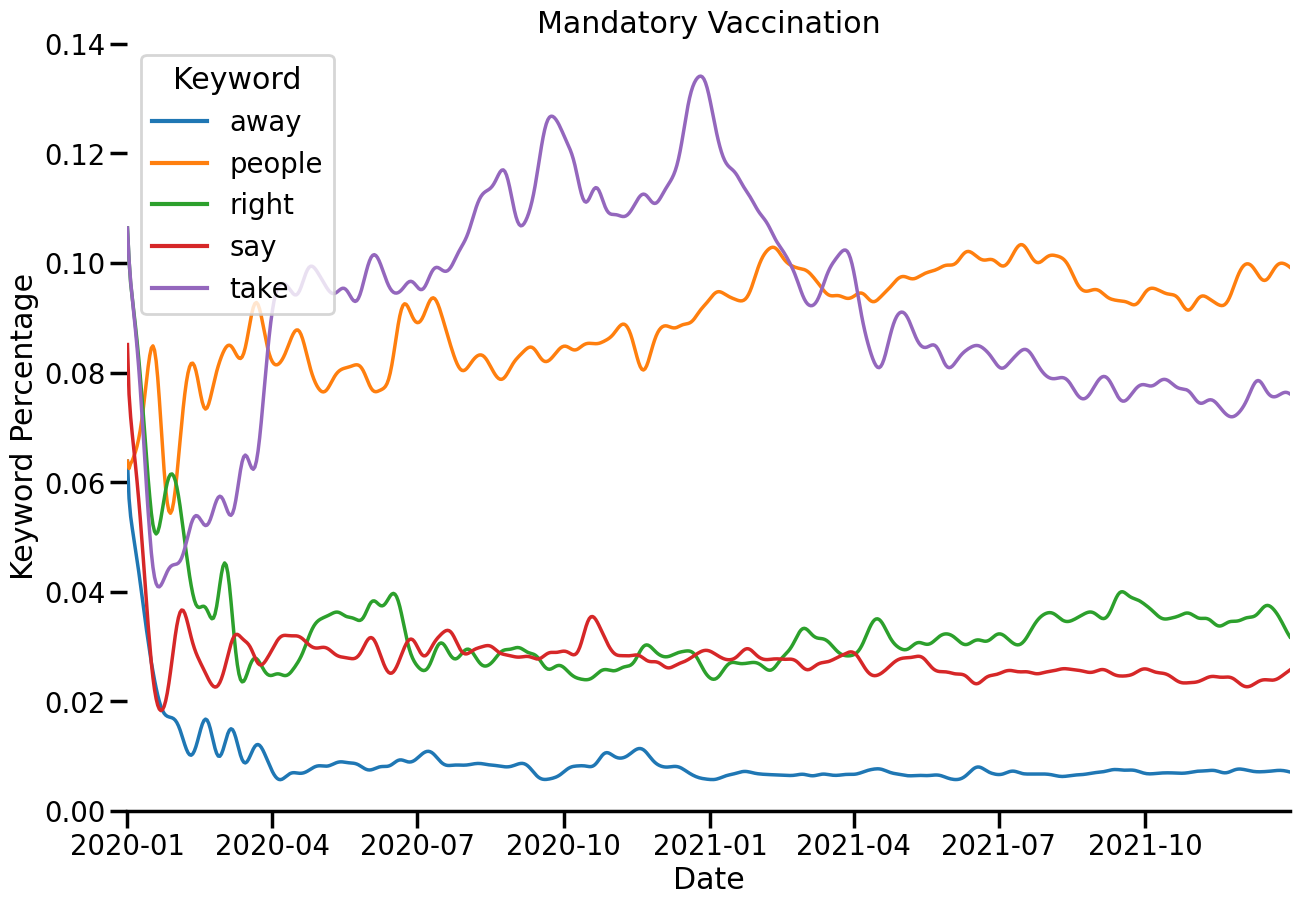

 12%|█▎        | 1/8 [00:01<00:12,  1.82s/it]<ipython-input-36-aa6845c28999>:13: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  topic_keywords = topic_keywords.groupby(['date', 'keyword']).agg({'count':'sum'}).reset_index()
<ipython-input-36-aa6845c28999>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)


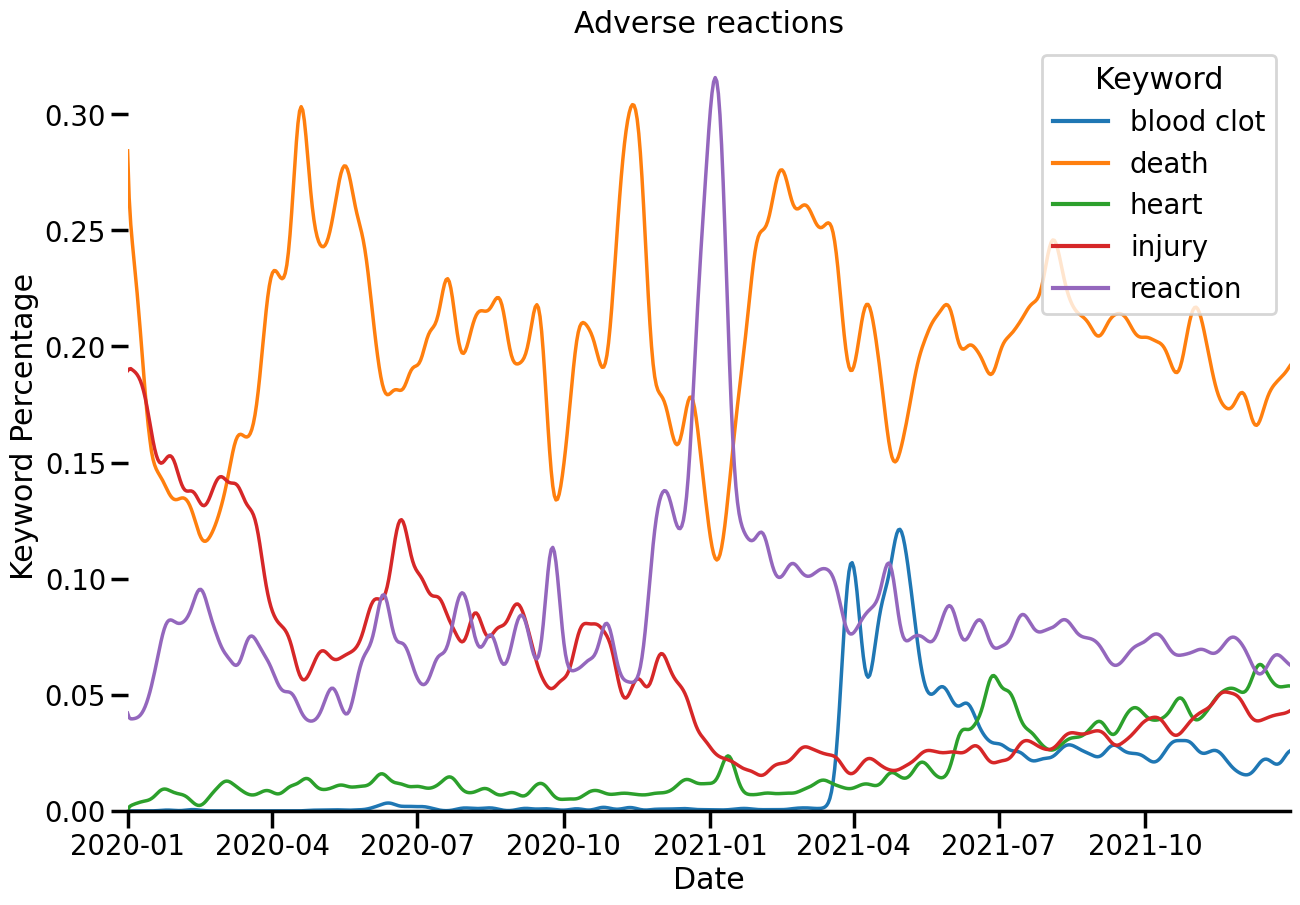

 25%|██▌       | 2/8 [00:02<00:08,  1.40s/it]<ipython-input-36-aa6845c28999>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)


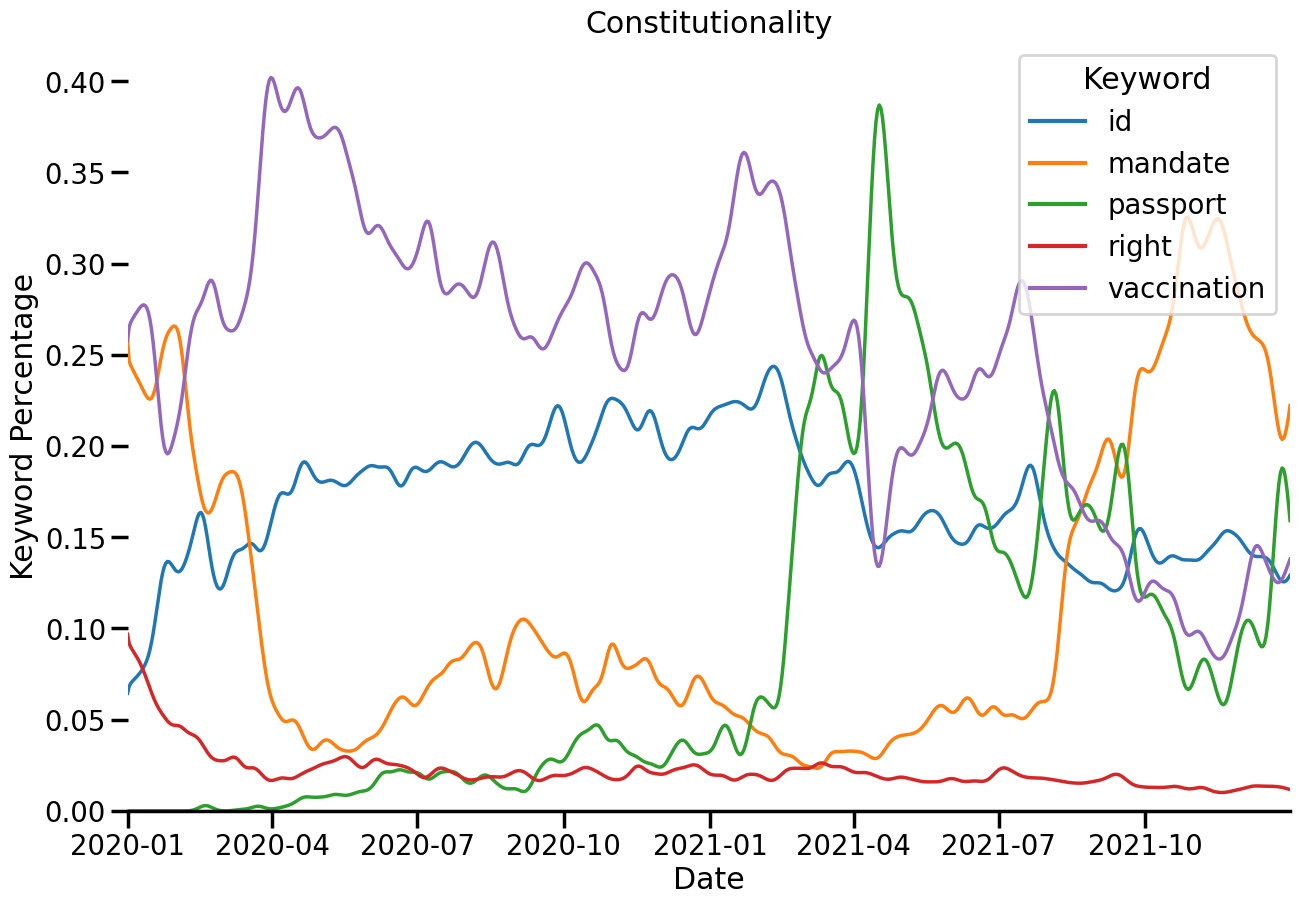

 38%|███▊      | 3/8 [00:04<00:06,  1.27s/it]<ipython-input-36-aa6845c28999>:13: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  topic_keywords = topic_keywords.groupby(['date', 'keyword']).agg({'count':'sum'}).reset_index()
<ipython-input-36-aa6845c28999>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)


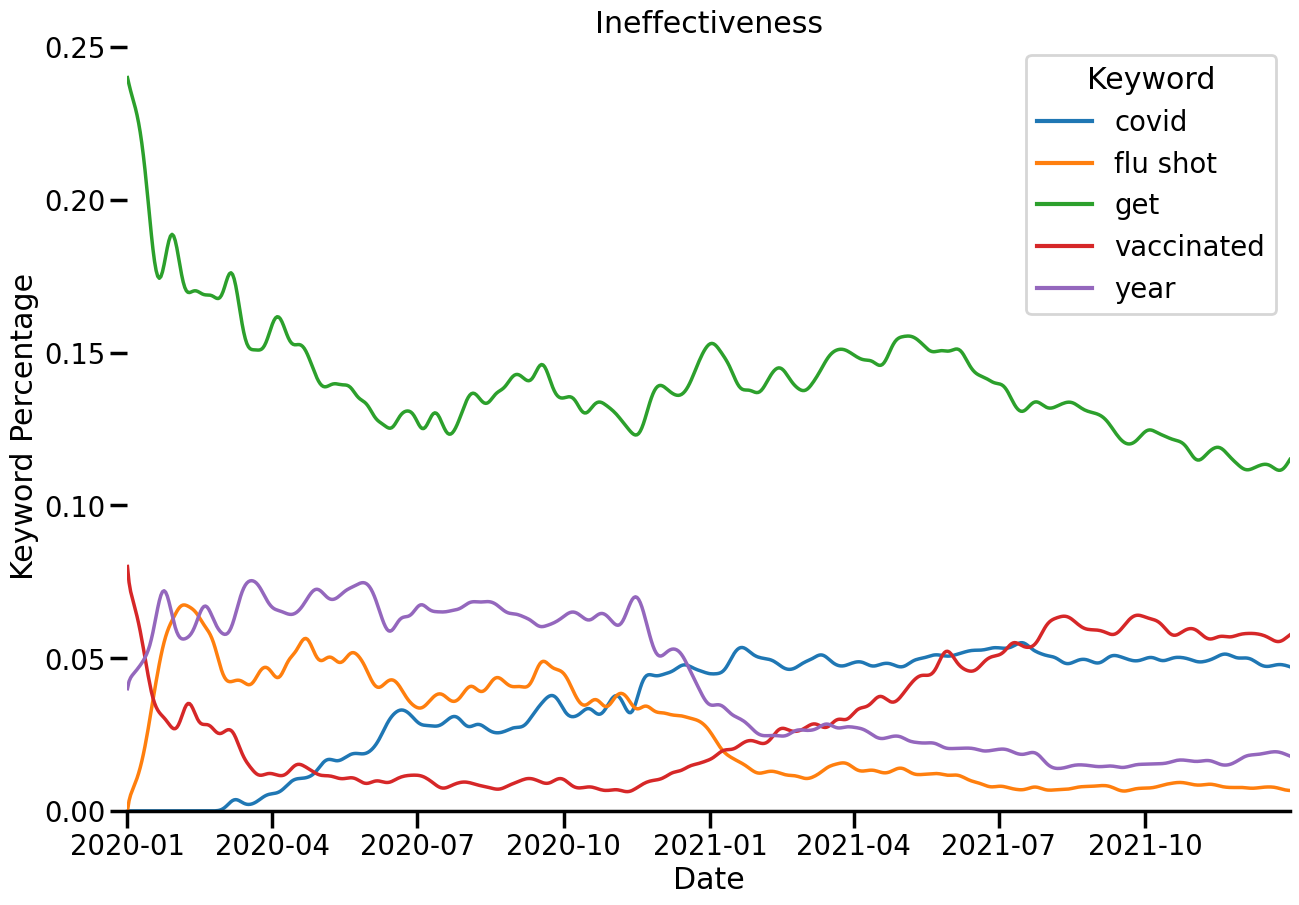

 50%|█████     | 4/8 [00:04<00:04,  1.14s/it]<ipython-input-36-aa6845c28999>:13: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  topic_keywords = topic_keywords.groupby(['date', 'keyword']).agg({'count':'sum'}).reset_index()
<ipython-input-36-aa6845c28999>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)


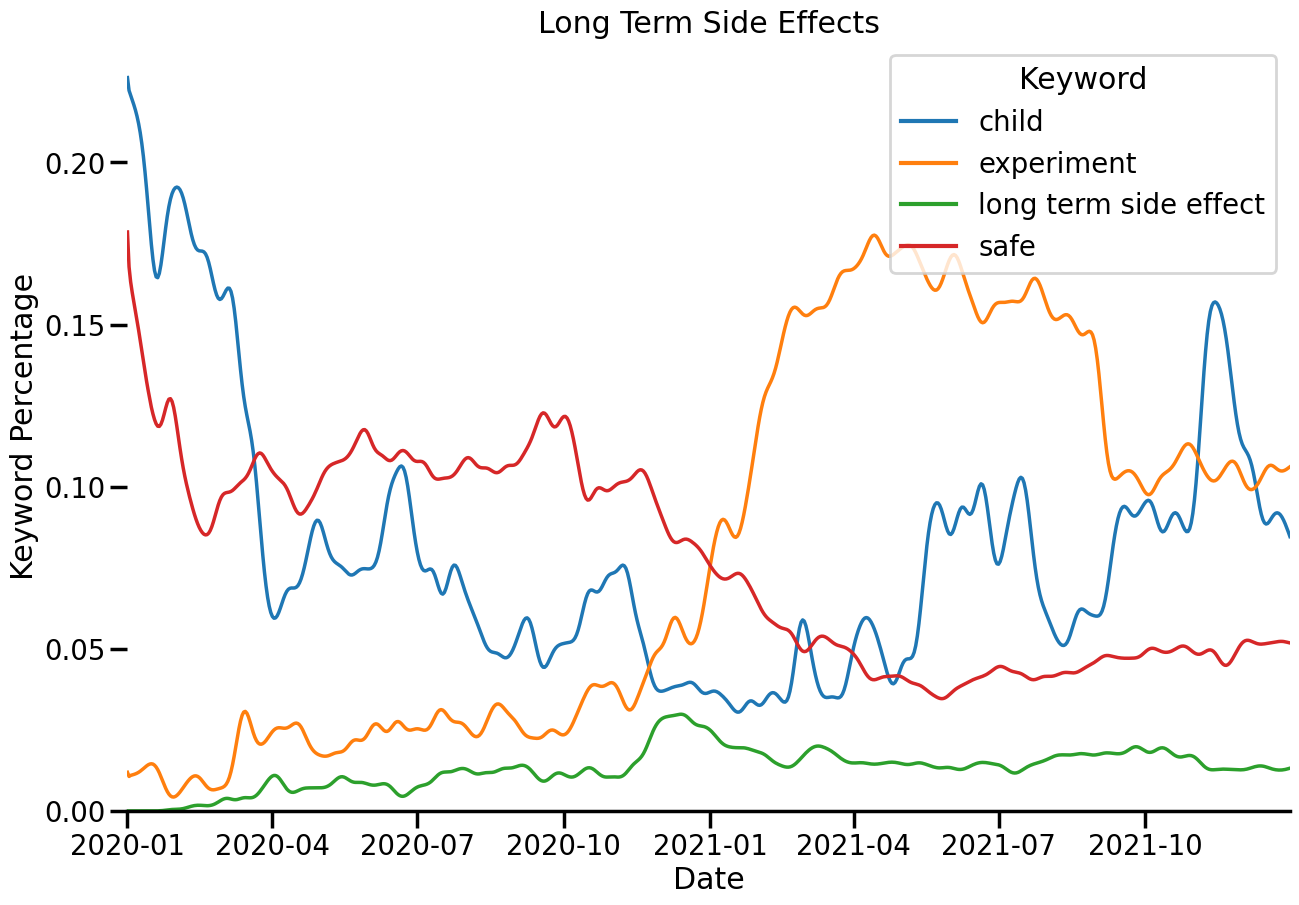

 62%|██████▎   | 5/8 [00:06<00:03,  1.10s/it]<ipython-input-36-aa6845c28999>:13: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  topic_keywords = topic_keywords.groupby(['date', 'keyword']).agg({'count':'sum'}).reset_index()
<ipython-input-36-aa6845c28999>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)


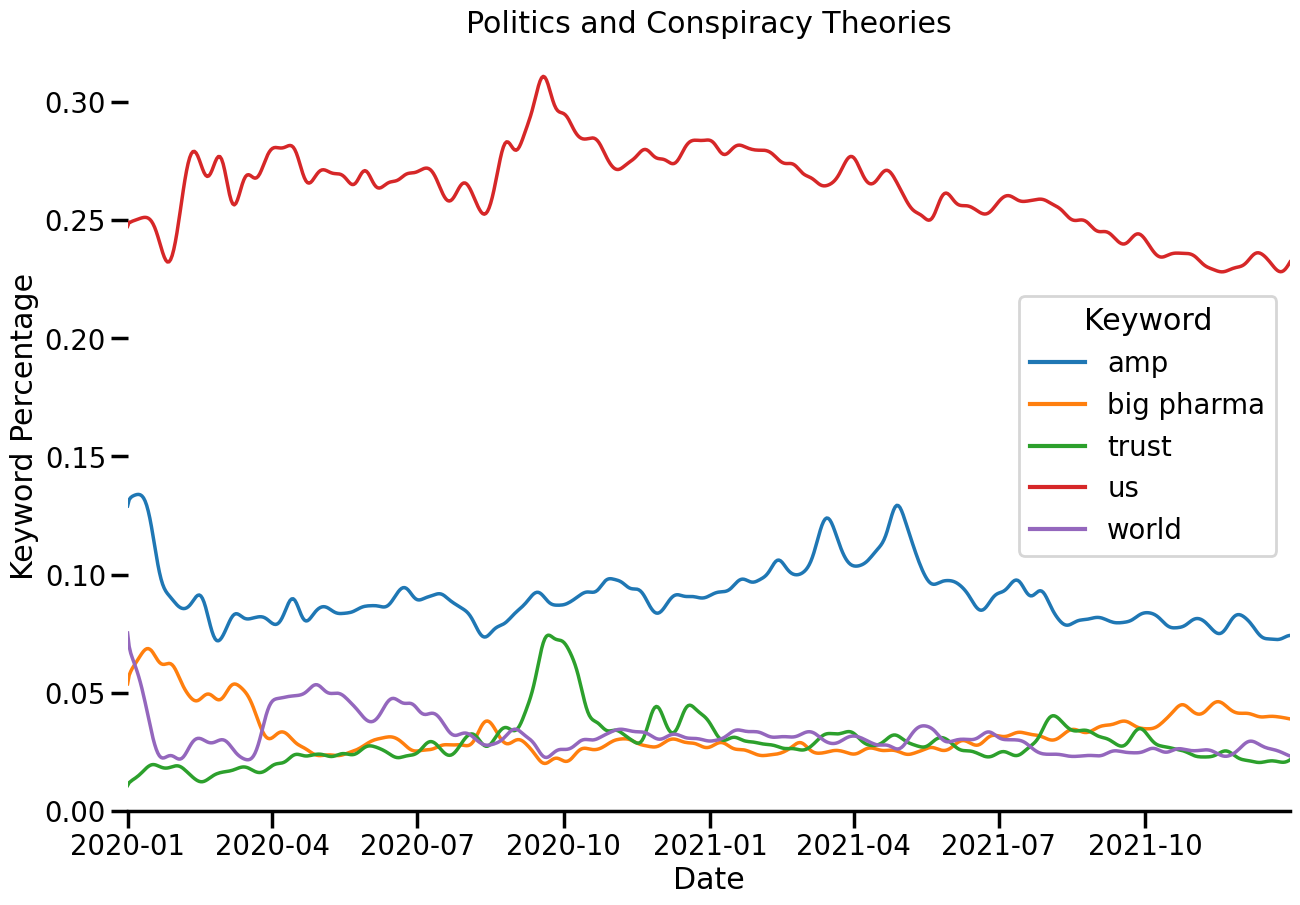

 75%|███████▌  | 6/8 [00:07<00:02,  1.10s/it]<ipython-input-36-aa6845c28999>:13: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype=datetime64[ns])
  topic_keywords = topic_keywords.groupby(['date', 'keyword']).agg({'count':'sum'}).reset_index()
<ipython-input-36-aa6845c28999>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)


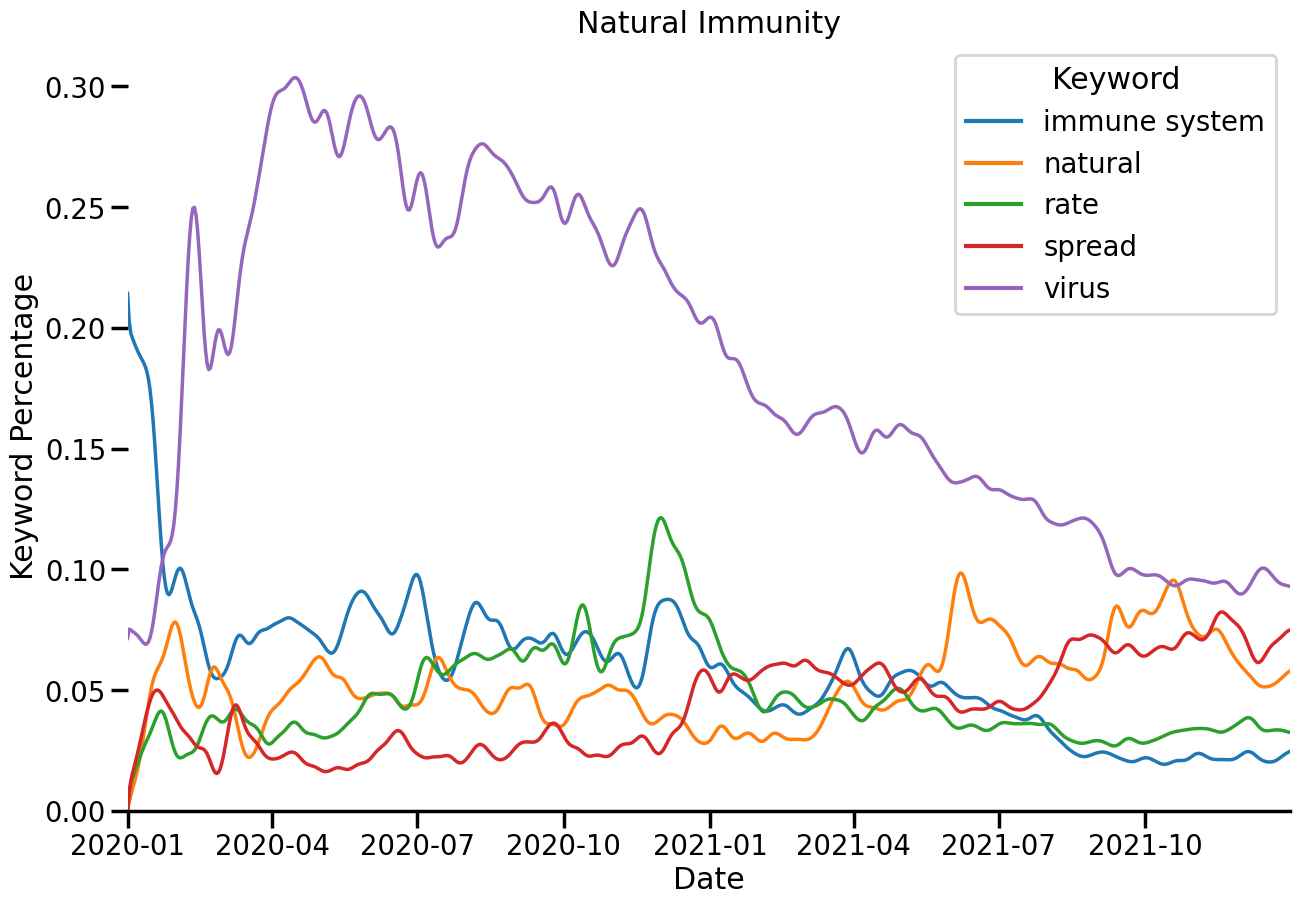

 88%|████████▊ | 7/8 [00:08<00:01,  1.10s/it]<ipython-input-36-aa6845c28999>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)


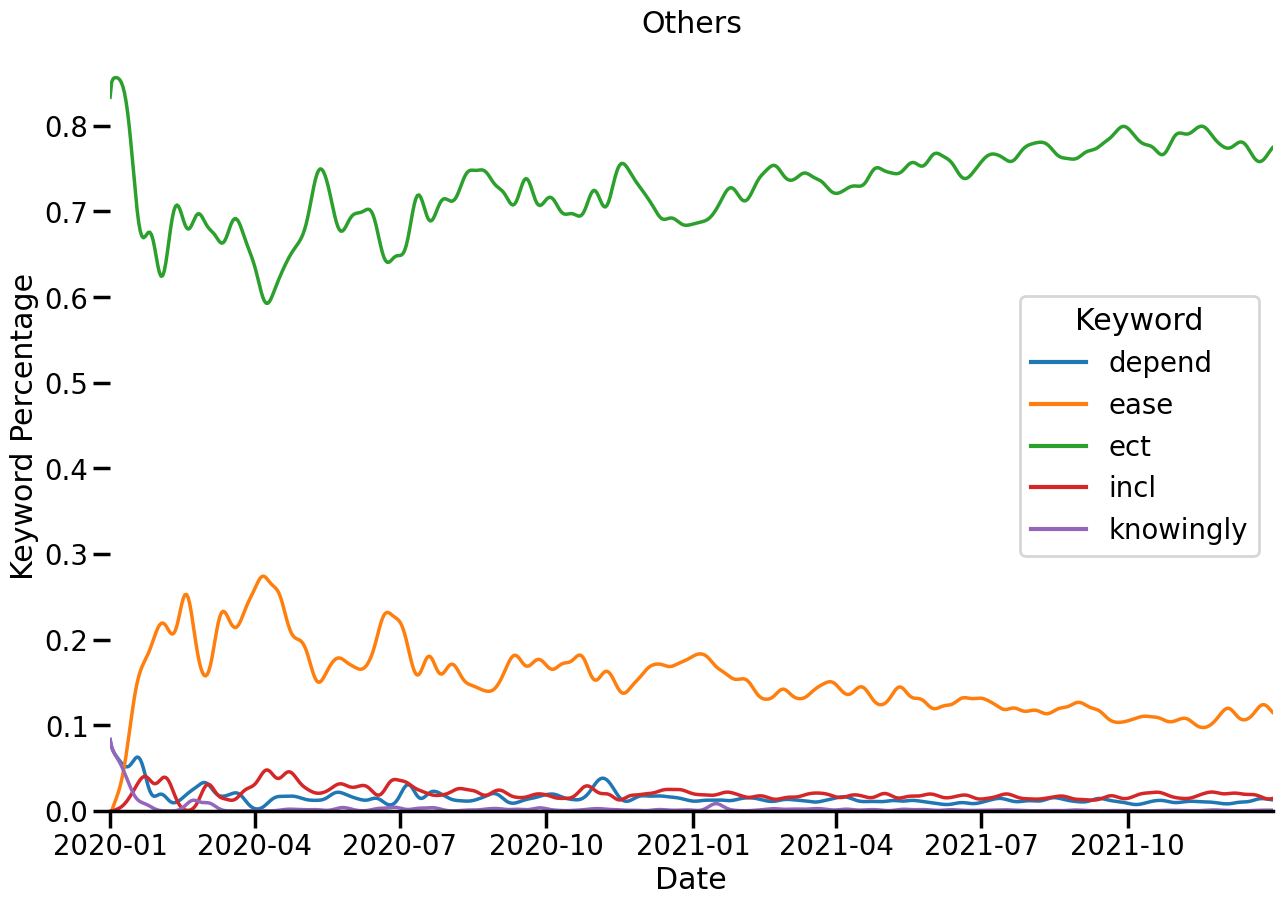

100%|██████████| 8/8 [00:09<00:00,  1.16s/it]


In [36]:
plt_path_topic = f"{supp_figures_path}/topic_keyword_counts"
os.makedirs(plt_path_topic, exist_ok=True)

for topic in tqdm(range(1, 9)): 

    topic_keywords = pd.read_parquet(f"{day_keyword_count_path}/topic{topic}.parquet")
    topic_keywords['keyword'] = [top_10_keywords_for_each_topic_stemmed_reversed[topic].get(word, word) for word in topic_keywords['keyword'].values]

    if topic in collocations:
        column_name = ' '.join(collocations[topic])
        topic_keywords = topic_keywords[~topic_keywords['keyword'].isin(collocations[topic])]
        bigram_topic_keywords = date_and_bigram_collocations_df[['date', column_name]].melt(id_vars='date', var_name='keyword', value_name='count')
        topic_keywords = pd.concat([topic_keywords, bigram_topic_keywords], axis=0)

    topic_keywords = topic_keywords.groupby(['date', 'keyword']).agg({'count':'sum'}).reset_index()
    topic_keywords['date'] = pd.to_datetime(topic_keywords['date'])

    day_and_topic_count = topic_keywords[['date', 'count']].groupby('date').agg({'count':'sum'}).reset_index().rename(columns={'count':'counts'})
    topic_keywords = topic_keywords.join(day_and_topic_count.set_index('date'), on='date')
    topic_keywords['perc'] = topic_keywords['count'].values / topic_keywords['counts'].values

    top_keyword_count = 5
    sub_topic_keywords = topic_keywords[topic_keywords['keyword'].isin(top_10_keywords_combined[topic][:top_keyword_count])]
    while len(sub_topic_keywords['keyword'].unique()) < 5:
        top_keyword_count += 1
        sub_topic_keywords = topic_keywords[topic_keywords['keyword'].isin(top_10_keywords_combined[topic][:top_keyword_count])]
        if top_keyword_count == 11:
            break

    for kw in sub_topic_keywords['keyword'].unique():
        kw_df = sub_topic_keywords[sub_topic_keywords['keyword'] == kw]
        smoothing_steps = 2
        for _ in range(smoothing_steps):
            kw_df['perc'] = kw_df['perc'].rolling(15, win_type='gaussian', min_periods=1).mean(std=3)
        sub_topic_keywords.loc[sub_topic_keywords['keyword'] == kw,'perc'] = kw_df['perc'].values

    sub_topic_keywords_pivot = sub_topic_keywords.pivot_table(index='date', columns='keyword', values='perc').reset_index()
    sums = sub_topic_keywords_pivot.melt(id_vars='date', var_name='keyword', value_name='perc')

    if 'u' in list(sums['keyword'].unique()):
        sums['keyword'] = sums['keyword'].replace({'u':'us'})

    plt.figure(figsize=(15, 10))
    sns.lineplot(data=sums, x='date', y='perc', hue='keyword', linewidth=2.5)
    plt.ylim(0,)
    plt.margins(x=0)
    sns.despine(left=True)
    plt.xlabel('Date')
    plt.ylabel('Keyword Percentage')
    plt.legend(title='Keyword')
    plt.title(f"{main_configs['topic_names'][topic-1]}")
    plt.savefig(f"{plt_path_topic}/top_5_keywords_for_topic{topic}.pdf", bbox_inches='tight')
    plt.show()